In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from keras_facenet import FaceNet

data_path="../Data/black_images.csv"
checkpoint_path="../Models/FACENET/"
target_shape = (160, 160)

2023-01-24 20:58:29.911147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def preprocess_image(filename, label):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, (160, 160))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return (image, label)

In [3]:
# reading the CSV file
csvFile = pd.read_csv(data_path)
labels  = csvFile['id'].astype(str).tolist()
images  = csvFile['source'].astype(str).tolist()
image_count = len(labels)

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1)
dataset = dataset.map(preprocess_image)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.75))
val_dataset   = dataset.skip(round(image_count * 0.75))

batch_size = 360
fetch_size = 2

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(fetch_size)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(fetch_size)

Metal device set to: AMD Radeon Pro 5500M


2023-01-24 20:58:34.072256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 20:58:34.072996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-24 20:58:34.073039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 20:58:34.073400: I tensorflow/core/common_runtime/pluggable_device/plug

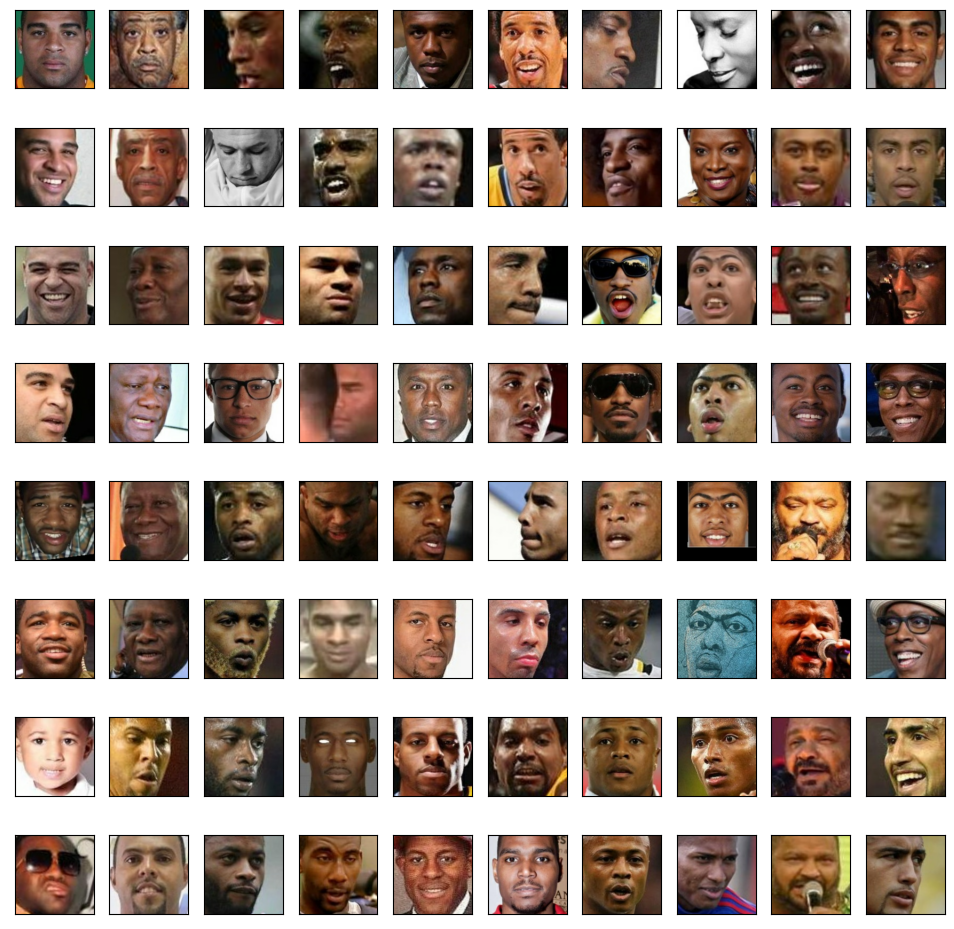

In [4]:
def visualize(image, label):
    """Visualize a few images from the supplied batches."""

    def show(ax, image):
        image = (image * 0.5) + 0.5
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(12, 12))

    axs = fig.subplots(8, 10)
    
    for i in range(8):
        for j in range(10):
            show(axs[i,j], image[i+10*j])
        

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [5]:
# create a facenet model
embedding = FaceNet(key = '20180402-114759',
        use_prebuilt=True,
        cache_folder='/Users/santhoshnarayanan/Documents/Turing/GPU/facenet_weights').model

# summarize input and output shape
print('Inputs: %s' % embedding.inputs)
print('Outputs: %s' % embedding.outputs)

Inputs: [<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'normalize')>]


In [6]:
trainable = False
for layer in embedding.layers:
    if layer.name == "AvgPool":
        trainable = True
    layer.trainable = trainable
    
embedding.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                             

 Block35_1_Branch_2_Conv2d_0b_3  (None, None, None,   96         ['Block35_1_Branch_2_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_1_Branch_1_Conv2d_0a_1  (None, None, None,   0          ['Block35_1_Branch_1_Conv2d_0a_1x
 x1_Activation (Activation)     32)                              1_BatchNorm[0][0]']              
                                                                                                  
 Block35_1_Branch_2_Conv2d_0b_3  (None, None, None,   0          ['Block35_1_Branch_2_Conv2d_0b_3x
 x3_Activation (Activation)     32)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_1

 x1_Activation (Activation)     32)                              1_BatchNorm[0][0]']              
                                                                                                  
 Block35_2_Branch_2_Conv2d_0b_3  (None, None, None,   0          ['Block35_2_Branch_2_Conv2d_0b_3x
 x3_Activation (Activation)     32)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_2_Branch_0_Conv2d_1x1   (None, None, None,   8192       ['Block35_1_Activation[0][0]']   
 (Conv2D)                       32)                                                               
                                                                                                  
 Block35_2_Branch_1_Conv2d_0b_3  (None, None, None,   9216       ['Block35_2_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    32)                              1_Activation[0][0]']             
          

 Block35_3_Branch_0_Conv2d_1x1   (None, None, None,   8192       ['Block35_2_Activation[0][0]']   
 (Conv2D)                       32)                                                               
                                                                                                  
 Block35_3_Branch_1_Conv2d_0b_3  (None, None, None,   9216       ['Block35_3_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    32)                              1_Activation[0][0]']             
                                                                                                  
 Block35_3_Branch_2_Conv2d_0c_3  (None, None, None,   9216       ['Block35_3_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    32)                              3_Activation[0][0]']             
                                                                                                  
 Block35_3_Branch_0_Conv2d_1x1_  (None, None, None,   96         ['Block35_3_Branch_0_Conv2d_1x1[0
 BatchNorm

                                                                                                  
 Block35_4_Branch_2_Conv2d_0c_3  (None, None, None,   9216       ['Block35_4_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    32)                              3_Activation[0][0]']             
                                                                                                  
 Block35_4_Branch_0_Conv2d_1x1_  (None, None, None,   96         ['Block35_4_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  32)                             ][0]']                           
                                                                                                  
 Block35_4_Branch_1_Conv2d_0b_3  (None, None, None,   96         ['Block35_4_Branch_1_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
          

 BatchNorm (BatchNormalization)  32)                             ][0]']                           
                                                                                                  
 Block35_5_Branch_1_Conv2d_0b_3  (None, None, None,   96         ['Block35_5_Branch_1_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_5_Branch_2_Conv2d_0c_3  (None, None, None,   96         ['Block35_5_Branch_2_Conv2d_0c_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_5

                                                                  'Mixed_6a_Branch_1_Conv2d_1a_3x3
                                                                 _Activation[0][0]',              
                                                                  'Mixed_6a_Branch_2_MaxPool_1a_3x
                                                                 3[0][0]']                        
                                                                                                  
 Block17_1_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Mixed_6a[0][0]']               
 x1 (Conv2D)                    128)                                                              
                                                                                                  
 Block17_1_Branch_1_Conv2d_0a_1  (None, None, None,   384        ['Block17_1_Branch_1_Conv2d_0a_1x
 x1_BatchNorm (BatchNormalizati  128)                            1[0][0]']                        
 on)      

                                                                                                  
 Block17_2_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_2_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_2_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_2_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
                                                                                                  
 Block17_2_Branch_1_Conv2d_0c_7  (None, None, None,   384        ['Block17_2_Branch_1_Conv2d_0c_7x
 x1_BatchNorm (BatchNormalizati  128)                            1[0][0]']                        
 on)                                                                                              
          

                                                                                                  
 add_7 (Add)                    (None, None, None,   0           ['Block17_2_Activation[0][0]',   
                                896)                              'lambda_7[0][0]']               
                                                                                                  
 Block17_3_Activation (Activati  (None, None, None,   0          ['add_7[0][0]']                  
 on)                            896)                                                              
                                                                                                  
 Block17_4_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Block17_3_Activation[0][0]']   
 x1 (Conv2D)                    128)                                                              
                                                                                                  
 Block17_4

 Block17_5_Branch_0_Conv2d_1x1   (None, None, None,   114688     ['Block17_4_Activation[0][0]']   
 (Conv2D)                       128)                                                              
                                                                                                  
 Block17_5_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_5_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_5_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_5_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
                                                                                                  
 Block17_5_Branch_1_Conv2d_0c_7  (None, None, None,   384        ['Block17_5_Branch_1_Conv2d_0c_7x
 x1_BatchN

 lambda_10 (Lambda)             (None, None, None,   0           ['Block17_6_Conv2d_1x1[0][0]']   
                                896)                                                              
                                                                                                  
 add_10 (Add)                   (None, None, None,   0           ['Block17_5_Activation[0][0]',   
                                896)                              'lambda_10[0][0]']              
                                                                                                  
 Block17_6_Activation (Activati  (None, None, None,   0          ['add_10[0][0]']                 
 on)                            896)                                                              
                                                                                                  
 Block17_7_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Block17_6_Activation[0][0]']   
 x1 (Conv2

 x7_Activation (Activation)     128)                             7_BatchNorm[0][0]']              
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1   (None, None, None,   114688     ['Block17_7_Activation[0][0]']   
 (Conv2D)                       128)                                                              
                                                                                                  
 Block17_8_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_8_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_8_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
          

                                896)                                                              
                                                                                                  
 lambda_13 (Lambda)             (None, None, None,   0           ['Block17_9_Conv2d_1x1[0][0]']   
                                896)                                                              
                                                                                                  
 add_13 (Add)                   (None, None, None,   0           ['Block17_8_Activation[0][0]',   
                                896)                              'lambda_13[0][0]']              
                                                                                                  
 Block17_9_Activation (Activati  (None, None, None,   0          ['add_13[0][0]']                 
 on)                            896)                                                              
          

                                                                                                  
 Mixed_7a_Branch_2_Conv2d_0b_3x  (None, None, None,   589824     ['Mixed_7a_Branch_2_Conv2d_0a_1x1
 3 (Conv2D)                     256)                             _Activation[0][0]']              
                                                                                                  
 Mixed_7a_Branch_0_Conv2d_0a_1x  (None, None, None,   768        ['Mixed_7a_Branch_0_Conv2d_0a_1x1
 1_BatchNorm (BatchNormalizatio  256)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Mixed_7a_Branch_1_Conv2d_0a_1x  (None, None, None,   768        ['Mixed_7a_Branch_1_Conv2d_0a_1x1
 1_BatchNorm (BatchNormalizatio  256)                            [0][0]']                         
 n)       

                                                                                                  
 Block8_1_Branch_1_Conv2d_0b_1x  (None, None, None,   0          ['Block8_1_Branch_1_Conv2d_0b_1x3
 3_Activation (Activation)      192)                             _BatchNorm[0][0]']               
                                                                                                  
 Block8_1_Branch_0_Conv2d_1x1 (  (None, None, None,   344064     ['Mixed_7a[0][0]']               
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_1_Branch_1_Conv2d_0c_3x  (None, None, None,   110592     ['Block8_1_Branch_1_Conv2d_0b_1x3
 1 (Conv2D)                     192)                             _Activation[0][0]']              
                                                                                                  
 Block8_1_

                                                                                                  
 Block8_2_Conv2d_1x1 (Conv2D)   (None, None, None,   689920      ['Block8_2_Concatenate[0][0]']   
                                1792)                                                             
                                                                                                  
 lambda_16 (Lambda)             (None, None, None,   0           ['Block8_2_Conv2d_1x1[0][0]']    
                                1792)                                                             
                                                                                                  
 add_16 (Add)                   (None, None, None,   0           ['Block8_1_Activation[0][0]',    
                                1792)                             'lambda_16[0][0]']              
                                                                                                  
 Block8_2_

 3_BatchNorm (BatchNormalizatio  192)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Block8_4_Branch_1_Conv2d_0b_1x  (None, None, None,   0          ['Block8_4_Branch_1_Conv2d_0b_1x3
 3_Activation (Activation)      192)                             _BatchNorm[0][0]']               
                                                                                                  
 Block8_4_Branch_0_Conv2d_1x1 (  (None, None, None,   344064     ['Block8_3_Activation[0][0]']    
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_4_Branch_1_Conv2d_0c_3x  (None, None, None,   110592     ['Block8_4_Branch_1_Conv2d_0b_1x3
 1 (Conv2D

                                                                  'Block8_5_Branch_1_Conv2d_0c_3x1
                                                                 _Activation[0][0]']              
                                                                                                  
 Block8_5_Conv2d_1x1 (Conv2D)   (None, None, None,   689920      ['Block8_5_Concatenate[0][0]']   
                                1792)                                                             
                                                                                                  
 lambda_19 (Lambda)             (None, None, None,   0           ['Block8_5_Conv2d_1x1[0][0]']    
                                1792)                                                             
                                                                                                  
 add_19 (Add)                   (None, None, None,   0           ['Block8_4_Activation[0][0]',    
          

In [7]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + "model.{epoch:02d}-{val_loss:.2f}.h5",
                                       monitor="val_loss",
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode="min",
                                       save_freq="epoch")]

embedding.compile(optimizer=optimizers.Adam(learning_rate=3e-4), 
                      weighted_metrics=[], loss=tfa.losses.TripletHardLoss(margin = 0.2))
embedding.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=my_callbacks)

Epoch 1/20


2023-01-24 20:58:45.444151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 0.1610

2023-01-24 21:00:37.215542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 158s 2s/step - loss: 0.1610 - val_loss: 0.1612
Epoch 2/20
 5/96 [>.............................] - ETA: 1:44 - loss: 0.1381

KeyboardInterrupt: 